In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)

train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)

nh = 50
bs = 512
c = y_train.max().item() + 1

loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
       partial(AvgStatsCallback, accuracy),
       CudaCallback,
       partial(BatchTransformXCallback, mnist_view)]

In [5]:
nfs = [8, 16, 32, 64, 64]

In [6]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
%%time
run.fit(2, learn)

train: [1.50970578125, tensor(0.4919, device='cuda:0')]
valid: [0.42316279296875, tensor(0.8603, device='cuda:0')]
train: [0.26411359375, tensor(0.9170, device='cuda:0')]
valid: [0.19294384765625, tensor(0.9392, device='cuda:0')]
CPU times: user 3.09 s, sys: 428 ms, total: 3.51 s
Wall time: 3.12 s


## Batchnorm

Let's start by building our own `BatchNorm` layer from scratch.

In [35]:
class BatchNorm(nn.Module):
    
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom = mom
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('vars', torch.ones(1, nf, 1, 1))
        self.register_buffer('means', torch.ones(1, nf, 1, 1))
        
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

#### Linear Interpolation playground

In [17]:
a = torch.arange(10).float()
a

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [29]:
b = torch.empty([10]).fill_(1)
a_lin_interpolation = a.lerp(b, 0.9)
a_lin_interpolation

tensor([0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000])

In [30]:
def lin_interp(x, y, mom):
    for s, e in zip(x, y):
        m1 = s + mom * (e - s)
        print(m1)
    return m1
lin_interp(a, b, 0.9)

tensor(0.9000)
tensor(1.)
tensor(1.1000)
tensor(1.2000)
tensor(1.3000)
tensor(1.4000)
tensor(1.5000)
tensor(1.6000)
tensor(1.7000)
tensor(1.8000)


tensor(1.8000)

#### Back to batch norm

In [32]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed using batch norm
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=stride, bias = not bn), GeneralRelu(**kwargs)]
    if bn:
        layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [37]:
#export
def init_cnn_(module, fun):
    if isinstance(module, nn.Conv2d):
        fun(module.weight, a=.1)
        if getattr(module, 'bias', None) is not None:
            module.bias.data.zero_()
    for l in module.children():
        init_cnn_(l, fun)
        
def init_cnn(model, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(model, f)
    
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [38]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.26781728515625, tensor(0.9158, device='cuda:0')]
valid: [0.1316176025390625, tensor(0.9608, device='cuda:0')]


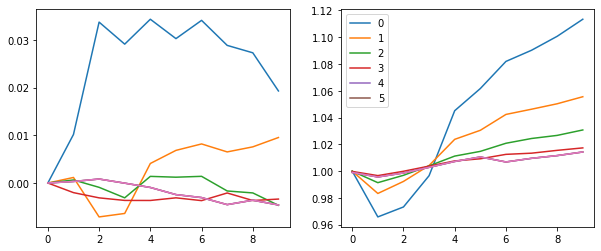

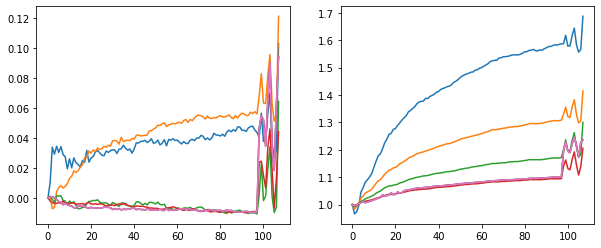

In [39]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [42]:
??conv_layer

In [45]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [46]:
%time run.fit(3, learn)

train: [0.258909140625, tensor(0.9189, device='cuda:0')]
valid: [0.15568994140625, tensor(0.9519, device='cuda:0')]
train: [0.089345576171875, tensor(0.9722, device='cuda:0')]
valid: [0.12089052734375, tensor(0.9638, device='cuda:0')]
train: [0.0658758935546875, tensor(0.9795, device='cuda:0')]
valid: [0.08763558349609375, tensor(0.9735, device='cuda:0')]
CPU times: user 2.86 s, sys: 0 ns, total: 2.86 s
Wall time: 2.27 s


#### Using Pytorch's Batch Norm

In [47]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed using batch norm
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=stride, bias = not bn), GeneralRelu(**kwargs)]
    if bn:
        layers.append(nn.BatchNorm2d(nf, momentum=0.1))
    return nn.Sequential(*layers)

In [48]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [49]:
%time run.fit(3, learn)

train: [0.21881951171875, tensor(0.9318, device='cuda:0')]
valid: [0.11089476318359374, tensor(0.9662, device='cuda:0')]
train: [0.063145908203125, tensor(0.9803, device='cuda:0')]
valid: [0.068544873046875, tensor(0.9810, device='cuda:0')]
train: [0.041806337890625, tensor(0.9871, device='cuda:0')]
valid: [0.05590709228515625, tensor(0.9838, device='cuda:0')]
CPU times: user 2.73 s, sys: 0 ns, total: 2.73 s
Wall time: 2.14 s


### With Scheduler

In [51]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.2)])

In [53]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [54]:
%time run.fit(8, learn)

train: [0.2436794921875, tensor(0.9266, device='cuda:0')]
valid: [0.1799642333984375, tensor(0.9438, device='cuda:0')]
train: [0.09174107421875, tensor(0.9721, device='cuda:0')]
valid: [0.1076772216796875, tensor(0.9671, device='cuda:0')]
train: [0.054258798828125, tensor(0.9830, device='cuda:0')]
valid: [0.06326447143554688, tensor(0.9807, device='cuda:0')]
train: [0.03140876220703125, tensor(0.9901, device='cuda:0')]
valid: [0.04712819213867187, tensor(0.9853, device='cuda:0')]
train: [0.0194296484375, tensor(0.9943, device='cuda:0')]
valid: [0.04773486938476563, tensor(0.9851, device='cuda:0')]
train: [0.01131025634765625, tensor(0.9971, device='cuda:0')]
valid: [0.0425028564453125, tensor(0.9881, device='cuda:0')]
train: [0.006414893188476562, tensor(0.9987, device='cuda:0')]
valid: [0.040887310791015624, tensor(0.9888, device='cuda:0')]
train: [0.0043182284545898435, tensor(0.9994, device='cuda:0')]
valid: [0.041583544921875, tensor(0.9887, device='cuda:0')]
CPU times: user 7.2 s,

## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

In [56]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1, 2, 3), keepdim=True)
        v = x.var((1, 2, 3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x * self.mult + self.add

In [58]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=stride, bias=True), GeneralRelu(**kwargs)]
    if bn:
        layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [59]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [60]:
%time run.fit(3, learn)

train: [nan, tensor(0.1199, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.21 s, sys: 0 ns, total: 3.21 s
Wall time: 2.61 s


### Instance norm

In [74]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    
    def __init__(self, nf, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        
    def forward(self, x):
        m = x.mean((2, 3), keepdim=True)
        v = x.var((2, 3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x * self.mults + self.adds

In [75]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=stride, bias=True), GeneralRelu(**kwargs)]
    if bn:
        layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [76]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [77]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.2 s, sys: 0 ns, total: 3.2 s
Wall time: 2.61 s


### Group norm

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

In [79]:
### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

In [80]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [84]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed using batch norm
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=stride, bias = not bn), GeneralRelu(**kwargs)]
    if bn:
        layers.append(nn.BatchNorm2d(nf, momentum=0.1, eps=1e-1))
    return nn.Sequential(*layers)

In [85]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [86]:
%time run.fit(1, learn)

train: [2.28437578125, tensor(0.2152, device='cuda:0')]
valid: [9.862290625, tensor(0.3476, device='cuda:0')]
CPU times: user 52 s, sys: 0 ns, total: 52 s
Wall time: 51.7 s


In [112]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom = mom
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x * x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel() / nc)
        mom1 = 1 - (1 - self.mom)/math.sqrt(bs - 1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias * (1 - self.mom1) + self.mom1
        self.batch += bs
        self.step += 1
        
    def forward(self, x):
        if self.training:
            self.update_stats(x)
        sums = self.sums
        sqrs= self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums / c
        vars = (sqrs / c).sub_(means*means)
        if bool(self.batch < 20):
            vars.clamp_min_(0.01)
        x = (x - means).div_((vars.add_(self.eps)).sqrt())
        
        return x.mul_(self.mults).add_(self.adds)

In [113]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [114]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [115]:
%time run.fit(1, learn)

train: [0.3515332421875, tensor(0.9091, device='cuda:0')]
valid: [0.17685738525390626, tensor(0.9648, device='cuda:0')]
CPU times: user 2min 12s, sys: 0 ns, total: 2min 12s
Wall time: 2min 12s
